In [1]:
from skimage.transform import radon, iradon
import numpy as np
from skimage.draw import ellipse
import matplotlib.pyplot as plt
import phantominator as phm
from scipy.io import loadmat
from image_utils import (
    discrete_imshow,
    make_ellipse,
    make_rectangle,
    make_ellipse_thickness,
    smooth_zero_center,
    make_rocket_phantom,
    make_rocket_phantom2,
    make_simple_rocket_phantom,
    matrix_to_disk_domain,
    vector_to_disk_domain,
    vector_to_rect_domain,
)
from pathlib import Path

import matlab
import matlab.engine as matengine
import scipy.sparse as spl

import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
sns.set_theme(context="talk", style="white")

PROJECT_DIR = Path().resolve()
COURSE_PATH = PROJECT_DIR.parent

OUTPUT_DIR = PROJECT_DIR / "output"
OUTPUT_DIR.mkdir(exist_ok=True)

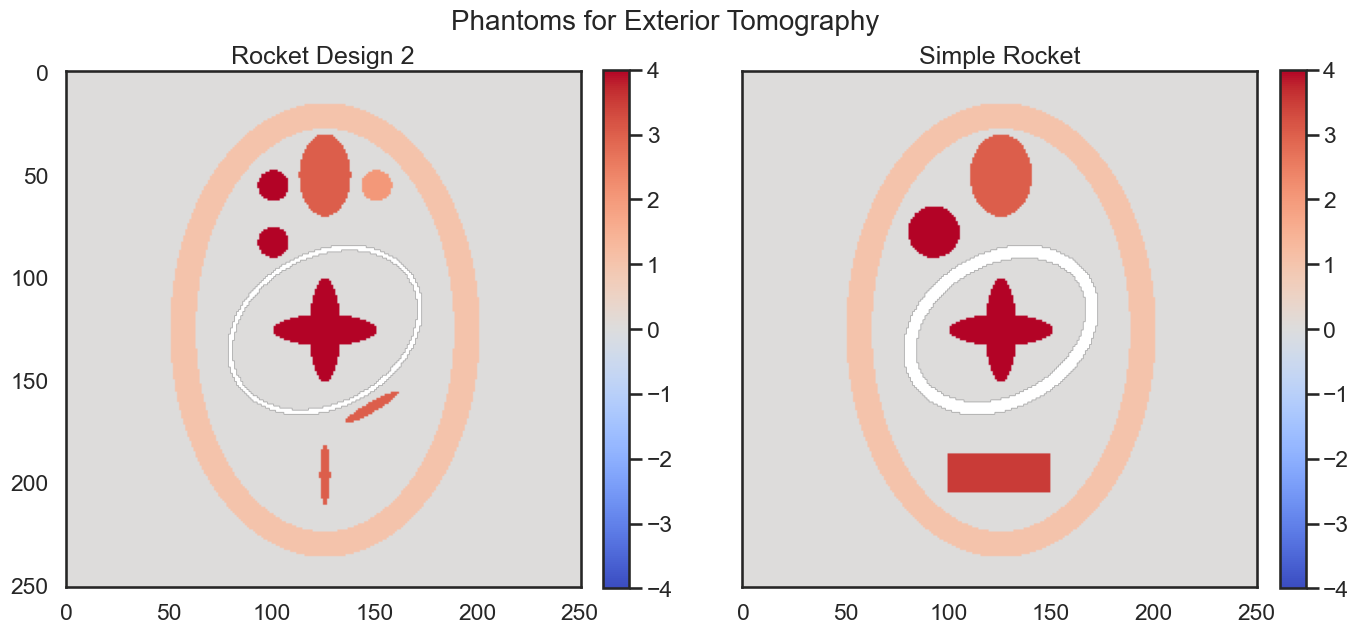

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

norm = plt.Normalize(vmin=-4, vmax=4)
cmap = plt.get_cmap("coolwarm")

# Rocket Design 2
X_2 = make_rocket_phantom2()
im = axs[0].imshow(X_2, norm=norm, cmap=cmap)
axs[0].set_title("Rocket Design 2")
plt.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)

# Rocket Design Simple
X_simple = make_simple_rocket_phantom(251, use_inf=True)
im = axs[1].imshow(X_simple, norm=norm, cmap=cmap)
axs[1].set_title("Simple Rocket")
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_yticks([])
# plt.tight_layout()

plt.suptitle("Phantoms for Exterior Tomography", fontsize=20, y=0.85)

plt.savefig(OUTPUT_DIR / "rocket_phantoms.png", dpi=600, bbox_inches="tight")

Text(0.5, 1.0, 'Rocket Design 2')

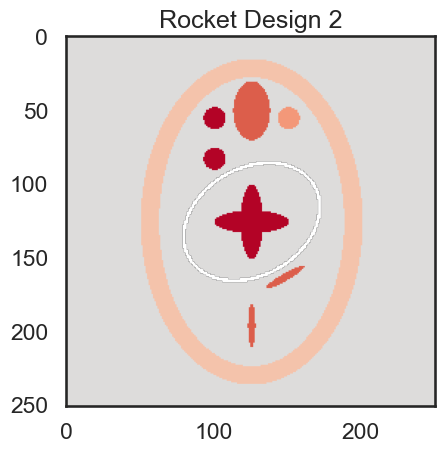

In [65]:
plt.figure()
plt.imshow(X_2, norm=norm, cmap=cmap)
plt.title("Rocket Design 2")

# Noisy Reconstruction

In [4]:
# Setup MATLAB
if 'HAS_RUN_MATLAB' not in globals():
    eng = matengine.start_matlab()
    HAS_RUN_MATLAB = True

eng.addpath(str((COURSE_PATH / "FA18").resolve()), nargout=0)
eng.addpath(str((COURSE_PATH / "AIRToolsII").resolve()), nargout=0)

eng.AIRToolsII_setup(nargout=0)

Text(0.5, 1.0, 'Reconstructed Image from Noisy Data')

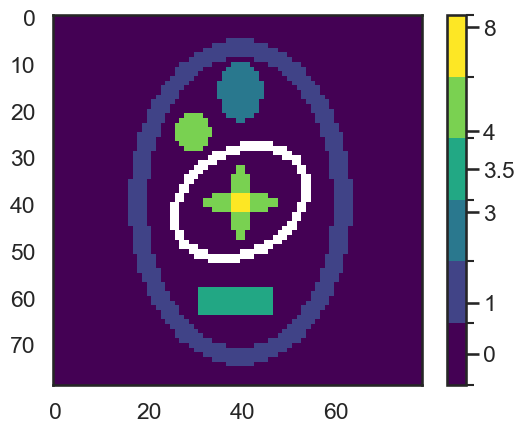

<Figure size 640x480 with 0 Axes>

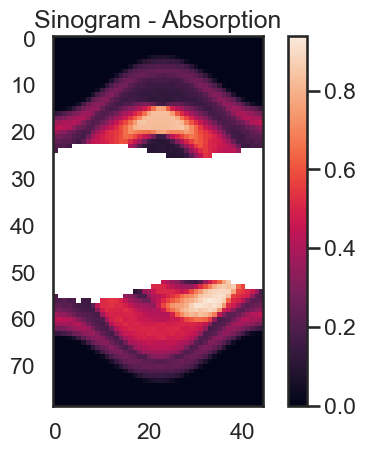

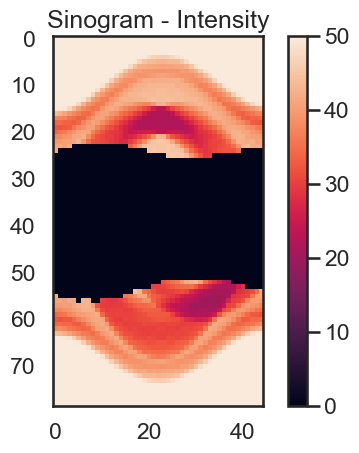

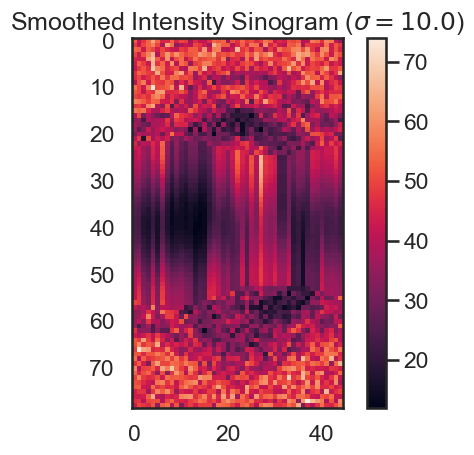

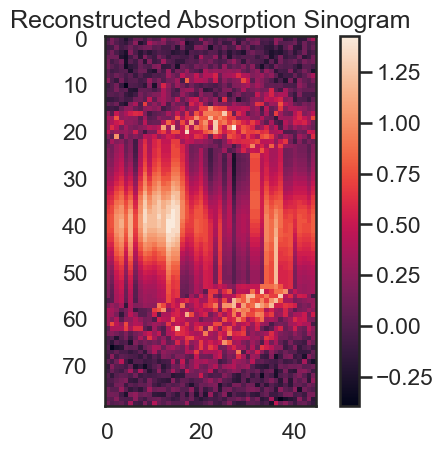

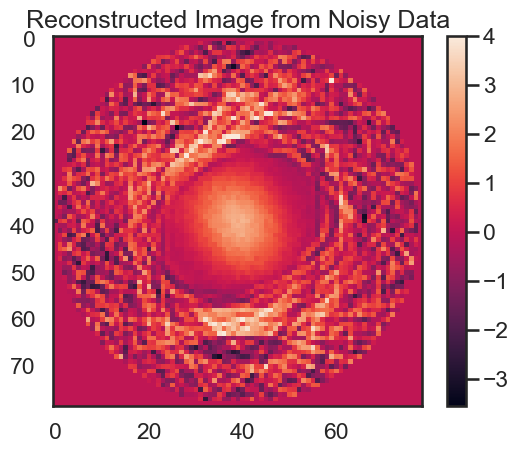

In [5]:
# Setup phantom
M = 45  # Num projects
N = 79  # Image linear size
I_0 = 5e1  # Passthrough intensity
sigma = 10.0  # Decay length

theta = np.linspace(0, 180, M, endpoint=False)

X = make_simple_rocket_phantom(N=N, use_inf=True)
discrete_imshow(X)

plt.figure()
A = radon(X, theta=theta) / N
I = I_0 * np.exp(-A)
I = np.nan_to_num(I, copy=False, nan=0.0)

plt.figure()
plt.imshow(A)
plt.title("Sinogram - Absorption")
plt.colorbar()

plt.figure()
plt.imshow(I)
plt.title("Sinogram - Intensity")
plt.colorbar()

# Add Poisson noise
I_noisy = np.random.poisson(I)

# Add Gaussian smoothing
I_smoothed = smooth_zero_center(I_noisy, sigma=sigma)
plt.figure()
plt.imshow(I_smoothed)
plt.title(f"Smoothed Intensity Sinogram ($σ={sigma}$)")
plt.colorbar()

# Convert noisy intensity back to absorption
A_recon = -np.log(np.maximum(I_smoothed, 1) / I_0)

plt.figure()
plt.imshow(A_recon)
plt.title("Reconstructed Absorption Sinogram")
plt.colorbar()

X_recon = (
    iradon(
        A_recon,
        theta=theta,
        output_size=N,
    )
    * N
)
# X_recon[X_recon < 0] = 0.0  # Clip negative values for better visualization

plt.figure()
plt.imshow(X_recon, vmax=4)
plt.colorbar()
plt.title("Reconstructed Image from Noisy Data")

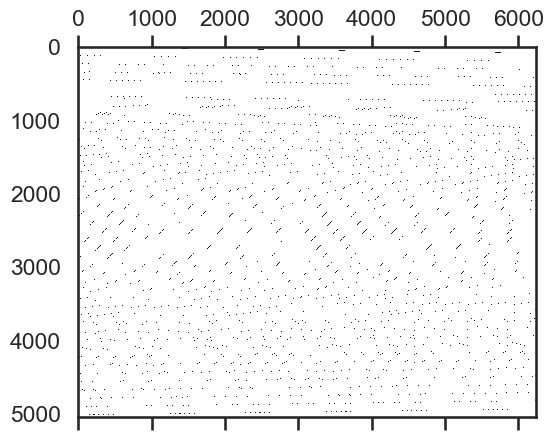

In [6]:
# Convert numpy array to MATLAB double array
theta_matlab = matlab.double(theta.tolist())
A_matlab = eng.dense_paralleltomo(float(N), theta_matlab)
plt.spy(A_matlab)

A = np.asarray(A_matlab)

A_disk = matrix_to_disk_domain(A)  # removes columns → (m × n_disk)

# X is the phantom (N × N), flatten first
x_disk = vector_to_disk_domain(X.flatten())  # removes elements → (n_disk,)

A_disk_sp = spl.coo_array(A_disk)

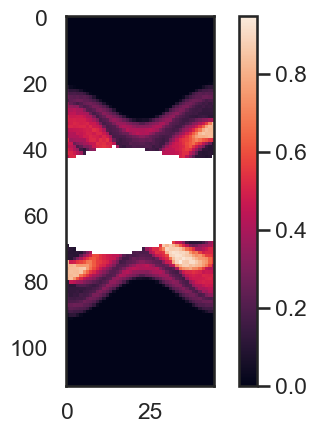

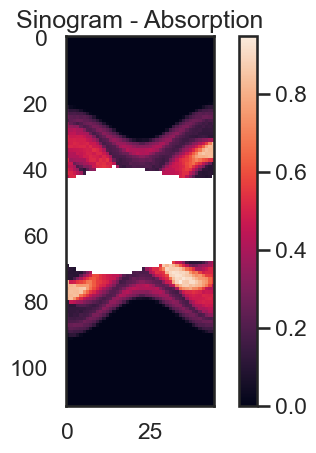

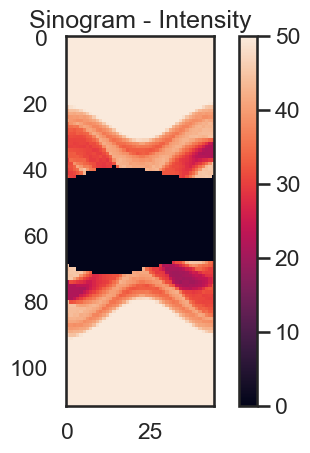

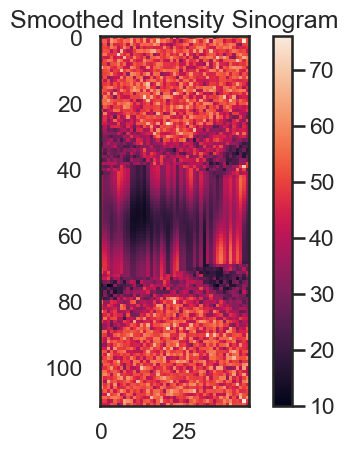

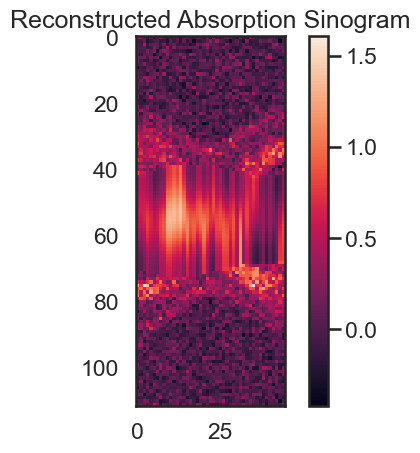

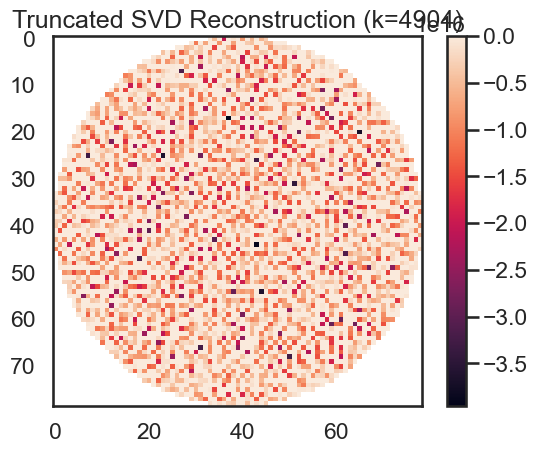

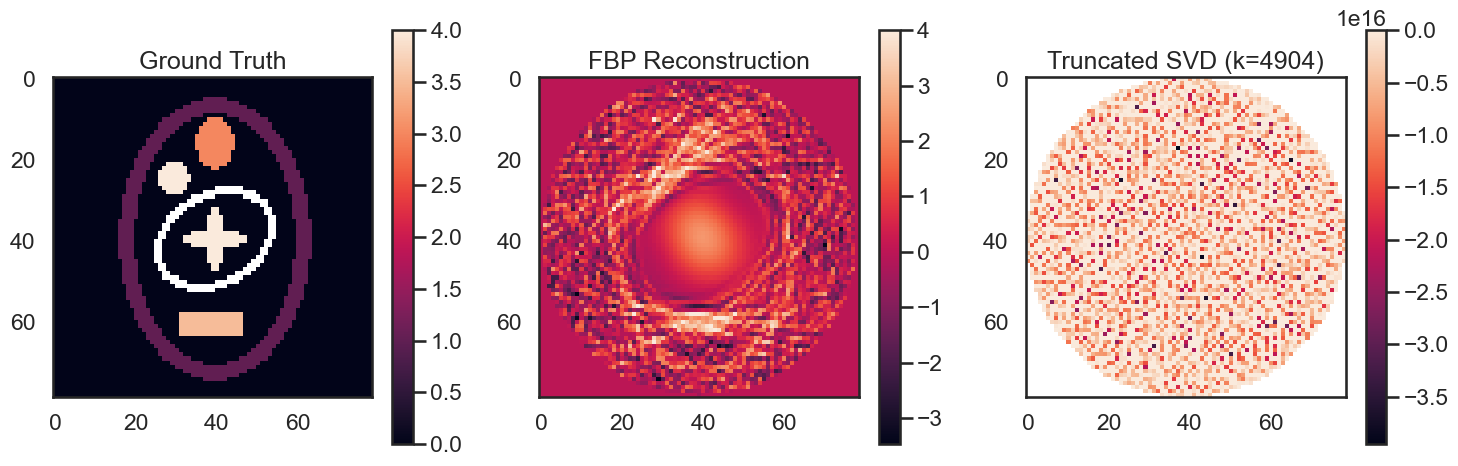

In [ ]:
p = A_disk_sp.shape[0] // M

# Create sinogram from phantom
A_sino = (((A_disk_sp @ x_disk).reshape(M, p)) / N).T
plt.imshow(A_sino)
plt.colorbar()

I = I_0 * np.exp(-A_sino)
I = np.nan_to_num(I, copy=False, nan=0.0)

plt.figure()
plt.imshow(A_sino)
plt.title("Sinogram - Absorption")
plt.colorbar()

plt.figure()
plt.imshow(I)
plt.title("Sinogram - Intensity")
plt.colorbar()

I_noisy = np.random.poisson(I).astype(float)

I_smoothed = smooth_zero_center(I_noisy, sigma=sigma)
plt.figure()
plt.imshow(I_smoothed)
plt.title("Smoothed Intensity Sinogram")
plt.colorbar()

# Convert noisy intensity back to absorption
A_recon = -np.log(np.maximum(I_smoothed, 1) / I_0)

plt.figure()
plt.imshow(A_recon)
plt.title("Reconstructed Absorption Sinogram")
plt.colorbar()

# Perform SVD on system matrix
k_svd = min(A_disk_sp.shape) - 1  # Number of singular values to keep
U, S, VT = spl.linalg.svds(A_disk_sp, k=k_svd)

# Sort by descending singular values (svds returns ascending order)
idx = np.argsort(S)[::-1]
U = U[:, idx]
S = S[idx]
VT = VT[idx, :]

# Truncated SVD reconstruction
k_trunc = k_svd  # Truncation parameter - adjust this!

# Method 1: Using pseudoinverse with truncation
S_inv = np.zeros_like(S)
S_inv[:k_trunc] = 1.0 / S[:k_trunc]

# Reconstruct: X = V * S^-1 * U^T * b
b = A_recon.T.flatten()  # to match system matrix convention
x_recon_svd_disk = (VT[:k_trunc, :].T @ (S_inv[:k_trunc] * (U[:, :k_trunc].T @ b)))
X_recon_svd = vector_to_rect_domain(x_recon_svd_disk, N) * N

plt.figure()
plt.imshow(X_recon_svd, vmax=4)
plt.title(f"Truncated SVD Reconstruction (k={k_trunc})")
plt.colorbar()

# Compare with FBP
X_recon_fbp = iradon(A_recon, theta=theta, output_size=N).T * N

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X, vmax=4)
plt.title("Ground Truth")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(X_recon_fbp, vmax=4)
plt.title("FBP Reconstruction")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(X_recon_svd, vmax=4)
plt.title(f"Truncated SVD (k={k_trunc})")
plt.colorbar()
plt.tight_layout()


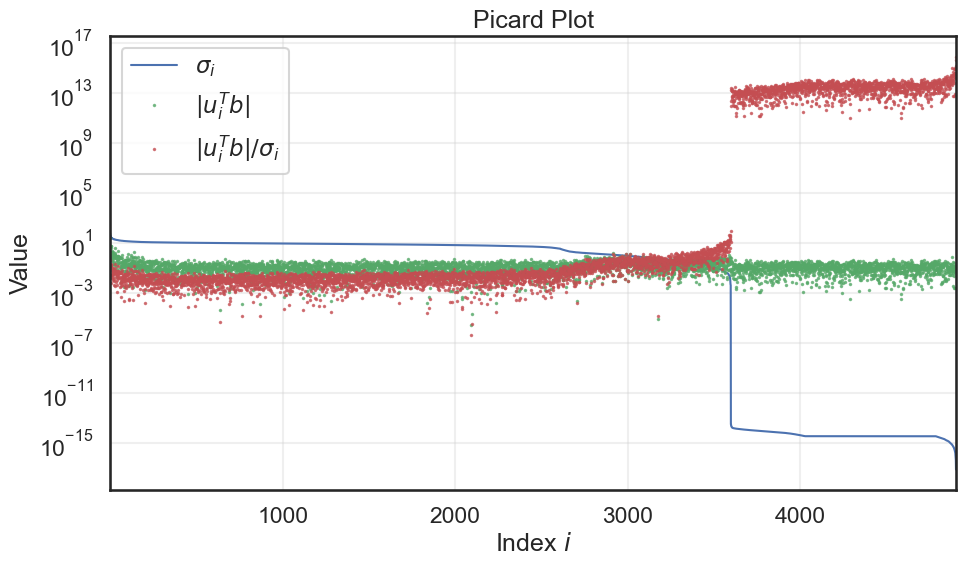

Suggested truncation parameter k ≈ 584


In [8]:
# Compute Picard plot components
b = A_recon.T.flatten()  # Right-hand side (sinogram as vector)
UTb = U.T @ b  # Fourier coefficients: U^T * b

# Picard plot
fig, ax = plt.subplots(figsize=(10, 6))

k_indices = np.arange(1, len(S) + 1)

# Singular values
ax.semilogy(k_indices, S, 'b-', label=r'$\sigma_i$', linewidth=1.5)
# Coefficients
ax.semilogy(k_indices, np.abs(UTb), 'g.', label=r'$|u_i^T b|$', markersize=3, alpha=0.7)
# Coefficients over singular values
ax.semilogy(k_indices, np.abs(UTb) / S, 'r.', label=r'$|u_i^T b| / \sigma_i$', markersize=3, alpha=0.7)

ax.set_xlabel('Index $i$')
ax.set_ylabel('Value')
ax.set_title('Picard Plot')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([1, len(S)])

plt.tight_layout()
plt.show()

# Find optimal truncation using discrete Picard condition
# The truncation should be where |U^T b| / sigma starts to grow
ratio = np.abs(UTb) / S

# Simple heuristic: find where the ratio starts increasing consistently
# (moving average to smooth out noise)
window = 20
ratio_smooth = np.convolve(ratio, np.ones(window)/window, mode='valid')
k_opt = np.argmin(ratio_smooth) + window // 2

print(f"Suggested truncation parameter k ≈ {k_opt}")


In [9]:
A_disk_sp.shape

(5040, 4905)

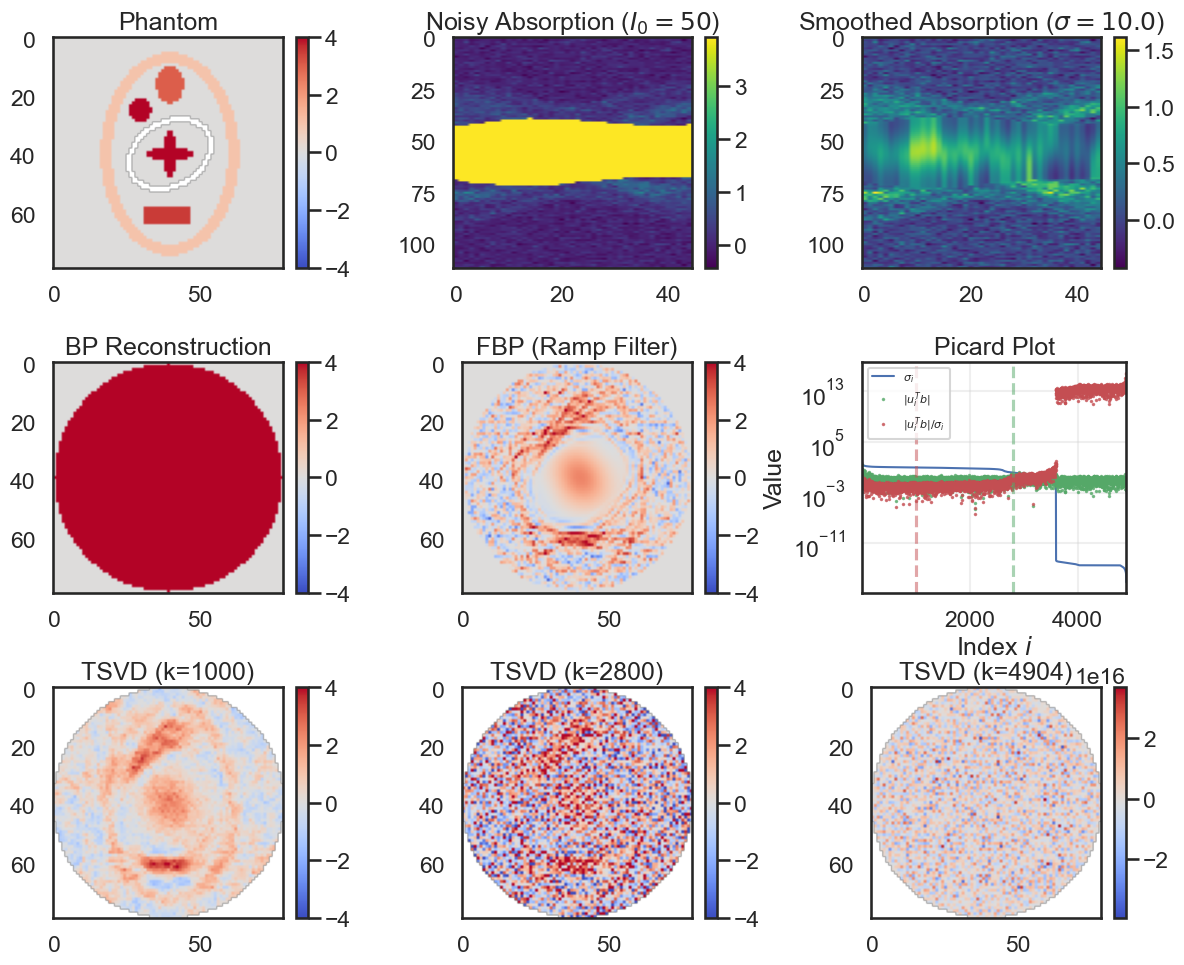

In [75]:
# Generate comprehensive comparison panel
k1 = 1000   # First truncation level
k2 = 2800  # Second truncation level
k3 = k_svd  # Maximum truncation level

# Compute reconstructions
# BP (backprojection without filter)
X_bp = iradon(A_recon, theta=theta, output_size=N, filter_name=None).T * N

# FBP (filtered backprojection with ramp filter)
X_fbp = iradon(A_recon, theta=theta, output_size=N, filter_name="ramp").T * N

# TSVD at k1
S_inv_k1 = np.zeros_like(S)
S_inv_k1[:k1] = 1.0 / S[:k1]
b = A_recon.T.flatten()
x_tsvd_k1 = (VT[:k1, :].T @ (S_inv_k1[:k1] * (U[:, :k1].T @ b))) * N
X_tsvd_k1 = vector_to_rect_domain(x_tsvd_k1, N)

# TSVD at k2
S_inv_k2 = np.zeros_like(S)
S_inv_k2[:k2] = 1.0 / S[:k2]
x_tsvd_k2 = (VT[:k2, :].T @ (S_inv_k2[:k2] * (U[:, :k2].T @ b))) * N
X_tsvd_k2 = vector_to_rect_domain(x_tsvd_k2, N)

# TSVD at k3
S_inv_k3 = np.zeros_like(S)
S_inv_k3[:k3] = 1.0 / S[:k3]
x_tsvd_k3 = (VT[:k3, :].T @ (S_inv_k3[:k3] * (U[:, :k3].T @ b))) * N
X_tsvd_k3 = vector_to_rect_domain(x_tsvd_k3, N)

# Noisy absorption sinogram (before smoothing)
A_noisy = -np.log(np.maximum(I_noisy, 1) / I_0)

# Picard plot components
UTb = U.T @ b

# Create 3x3 panel
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

vmax_img = 4
vmax_sino = np.percentile(A_recon[A_recon > 0], 95) if np.any(A_recon > 0) else 1

# Row 1: Phantom, Initial Sinogram, Smoothened Sinogram
im = axs[0, 0].imshow(X, cmap=cmap, norm=norm)
axs[0, 0].set_title("Phantom")
plt.colorbar(im, ax=axs[0, 0], fraction=0.046)

im = axs[0, 1].imshow(A_noisy, aspect="auto", cmap="viridis")
axs[0, 1].set_title(f"Noisy Absorption ($I_0 = {int(I_0)}$)")
plt.colorbar(im, ax=axs[0, 1], fraction=0.046)

im = axs[0, 2].imshow(A_recon, aspect="auto", cmap="viridis")
axs[0, 2].set_title(f"Smoothed Absorption ($σ={sigma}$)")
plt.colorbar(im, ax=axs[0, 2], fraction=0.046)

# Row 2: BP, FBP, Picard Plot
im = axs[1, 0].imshow(X_bp, cmap=cmap, norm=norm)
axs[1, 0].set_title("BP Reconstruction")
plt.colorbar(im, ax=axs[1, 0], fraction=0.046)

im = axs[1, 1].imshow(X_fbp, cmap=cmap, norm=norm)
axs[1, 1].set_title("FBP (Ramp Filter)")
plt.colorbar(im, ax=axs[1, 1], fraction=0.046)

# Picard plot
k_indices = np.arange(1, len(S) + 1)
axs[1, 2].semilogy(k_indices, S, 'b-', label=r'$\sigma_i$', linewidth=1.5)
axs[1, 2].semilogy(k_indices, np.abs(UTb), 'g.', label=r'$|u_i^T b|$', markersize=3, alpha=0.7)
axs[1, 2].semilogy(k_indices, np.abs(UTb) / S, 'r.', label=r'$|u_i^T b| / \sigma_i$', markersize=3, alpha=0.7)
axs[1, 2].axvline(k1, color='r', linestyle='--', alpha=0.5)
axs[1, 2].axvline(k2, color='g', linestyle='--', alpha=0.5)
axs[1, 2].set_xlabel('Index $i$')
axs[1, 2].set_ylabel('Value')
axs[1, 2].set_title('Picard Plot')
axs[1, 2].legend(fontsize=8, loc='upper left')
axs[1, 2].grid(True, alpha=0.3)
axs[1, 2].set_xlim([1, len(S)])

# Row 3: TSVD k1, TSVD k2, Ground Truth comparison
im = axs[2, 0].imshow(X_tsvd_k1, cmap=cmap, norm=norm)
axs[2, 0].set_title(f"TSVD (k={k1})")
plt.colorbar(im, ax=axs[2, 0], fraction=0.046)

im = axs[2, 1].imshow(X_tsvd_k2, cmap=cmap, norm=norm)
axs[2, 1].set_title(f"TSVD (k={k2})")
plt.colorbar(im, ax=axs[2, 1], fraction=0.046)

im = axs[2, 2].imshow(X_tsvd_k3, cmap=cmap)
axs[2, 2].set_title(f"TSVD (k={k3})")
plt.colorbar(im, ax=axs[2, 2], fraction=0.046)

plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.savefig(OUTPUT_DIR / "reconstruction_comparison.png", dpi=600, bbox_inches="tight")
plt.show()

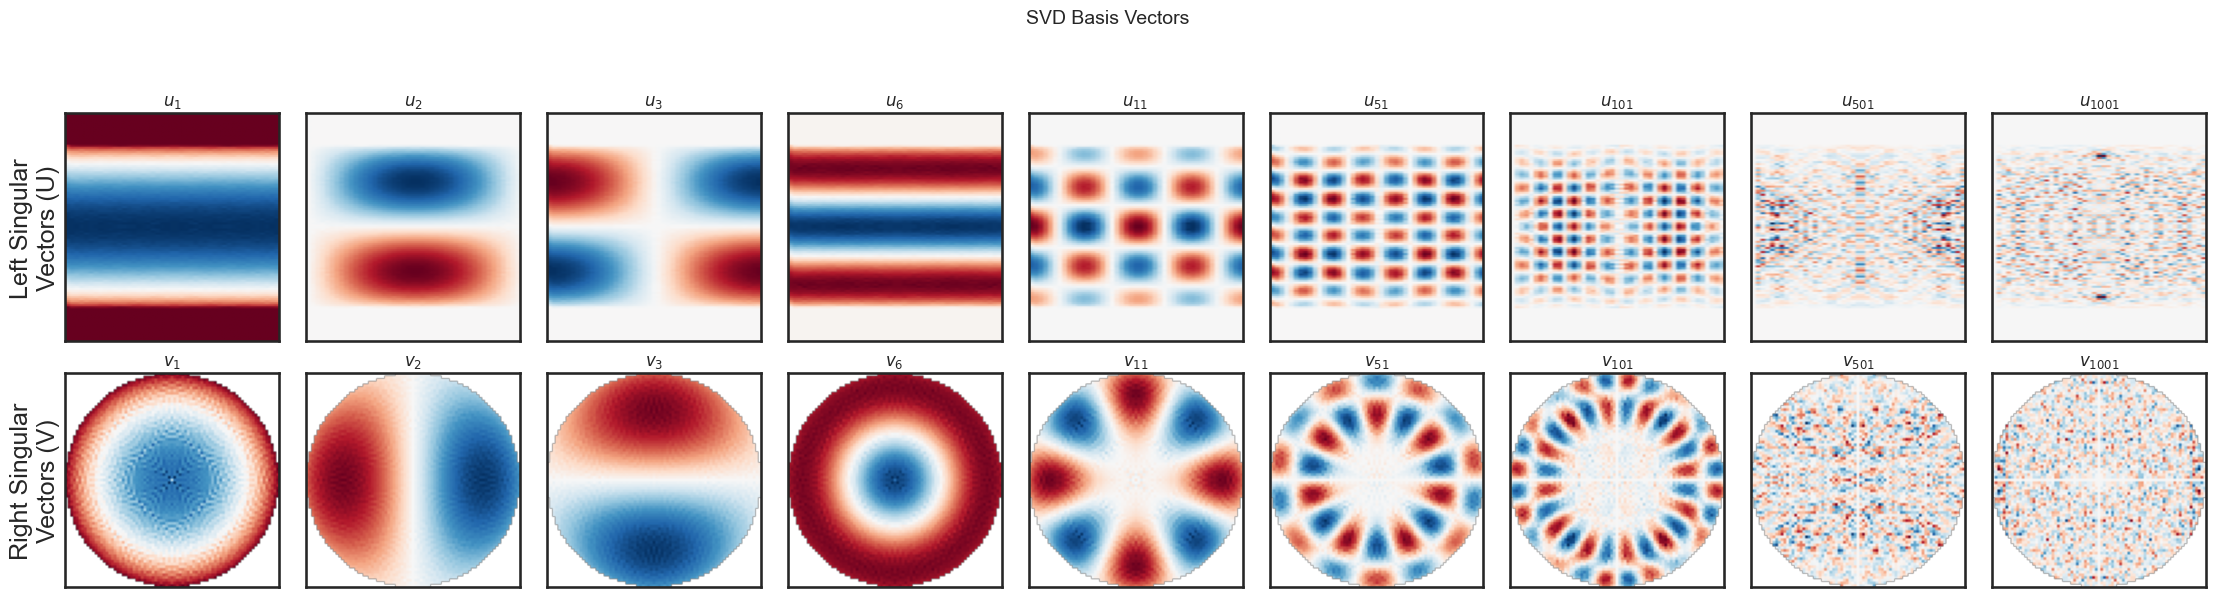

In [11]:
# SVD Vectors Visualization
# Show selected left (U) and right (V) singular vectors

# Select which singular vectors to display
vec_indices = [0, 1, 2, 5, 10, 50, 100, 500, 1000]
vec_indices = [i for i in vec_indices if i < k_svd]  # Filter valid indices

n_vecs = len(vec_indices)

# Create figure with 2 rows: U vectors (sinogram space) and V vectors (image space)
fig, axs = plt.subplots(2, n_vecs, figsize=(2.5 * n_vecs, 6))

# Row 1: Left singular vectors U (reshaped to sinogram)
for col, idx in enumerate(vec_indices):
    u_vec = U[:, idx].reshape(M, p).T  # Reshape to sinogram shape
    im = axs[0, col].imshow(u_vec, aspect="auto", cmap="RdBu_r")
    axs[0, col].set_title(f"$u_{{{idx+1}}}$", fontsize=12)
    axs[0, col].set_xticks([])
    axs[0, col].set_yticks([])
    if col == 0:
        axs[0, col].set_ylabel("Left Singular\nVectors (U)")

# Row 2: Right singular vectors V (reshaped to image)
for col, idx in enumerate(vec_indices):
    v_vec = VT[idx, :]  # V^T row = V column
    v_img = vector_to_rect_domain(v_vec, N)  # Reshape to image
    im = axs[1, col].imshow(v_img, cmap="RdBu_r")
    axs[1, col].set_title(f"$v_{{{idx+1}}}$", fontsize=12)
    axs[1, col].set_xticks([])
    axs[1, col].set_yticks([])
    if col == 0:
        axs[1, col].set_ylabel("Right Singular\nVectors (V)")

plt.suptitle("SVD Basis Vectors", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "svd_vectors.png", dpi=300, bbox_inches="tight")
plt.show()

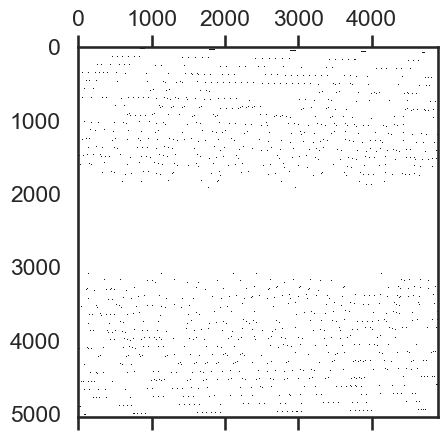

(5040, 4905)

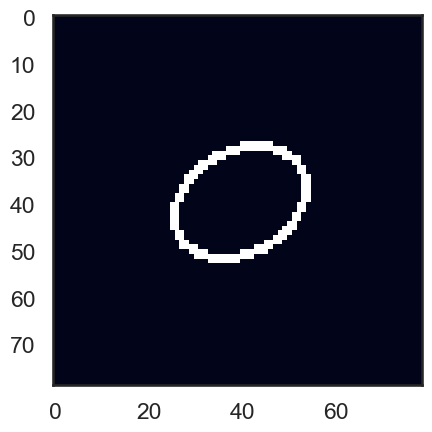

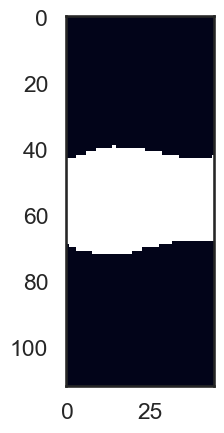

In [49]:
# Investigate limited angles
X_extreme = X.copy()
X_extreme[X_extreme < 10] = 0.0

plt.imshow(X_extreme)

x_extreme = vector_to_disk_domain(X_extreme.flatten())  # removes elements → (n_disk,)
A_extreme_sino = (((A_disk_sp @ x_extreme).reshape(M, p)) / N).T
plt.figure()
plt.imshow(A_extreme_sino)

line_integrals = A_extreme_sino.flatten(order="F")
mask = line_integrals == 0

A_disk_limited_angle = A_disk.copy()
A_disk_limited_angle[~mask, :] = 0.0
A_disk_limited_angle_sp = spl.coo_array(A_disk_limited_angle)
A_disk_limited_angle_sp.shape

In [48]:
A_extreme_sino.shape
# A_extreme_sino.shape[0] * A_extreme_sino.shape[1]

(112, 45)

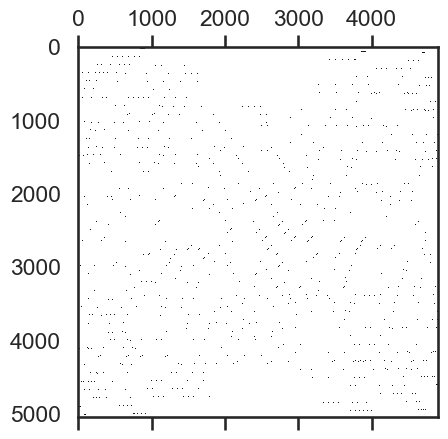

In [50]:
plt.spy(A_disk_limited_angle_sp.todense())

In [57]:
# U_l, S_l, VT_l = spl.linalg.svds(A_disk_limited_angle_sp, k=min(A_disk_limited_angle_sp.shape) - 1)
U_l, S_l, VT_l = spl.linalg.svds(A_disk_limited_angle_sp, k=1000)

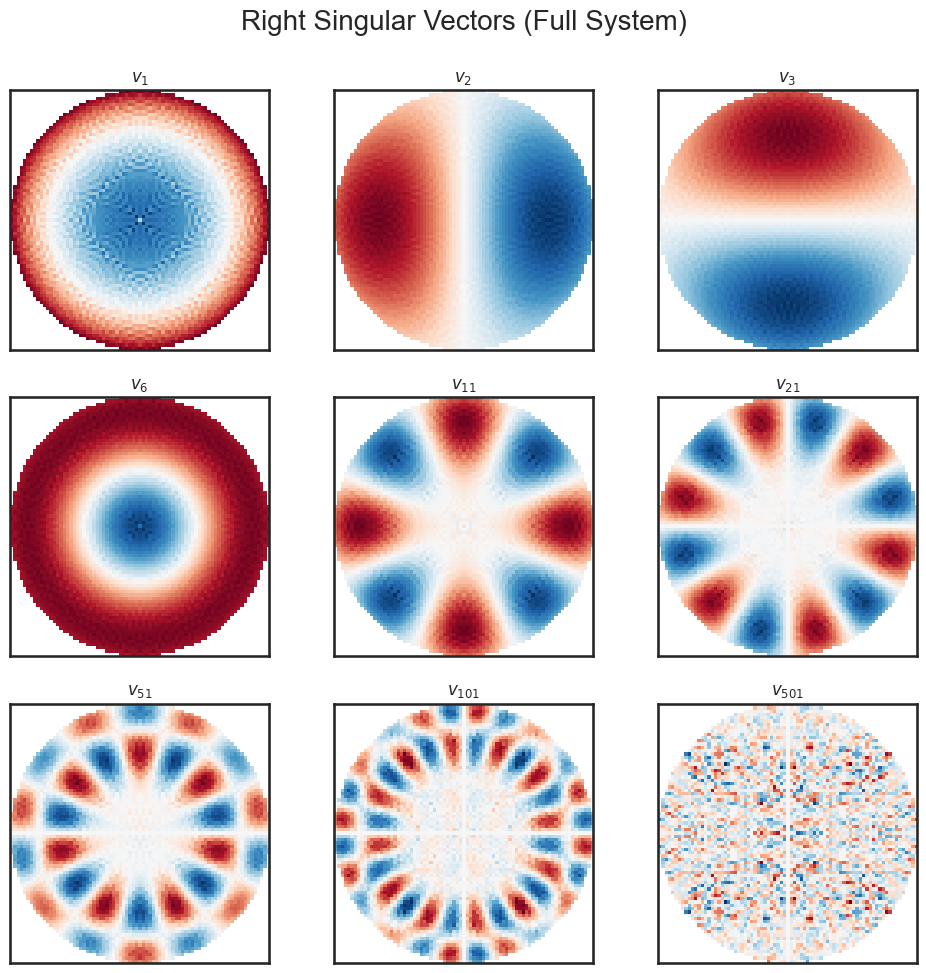

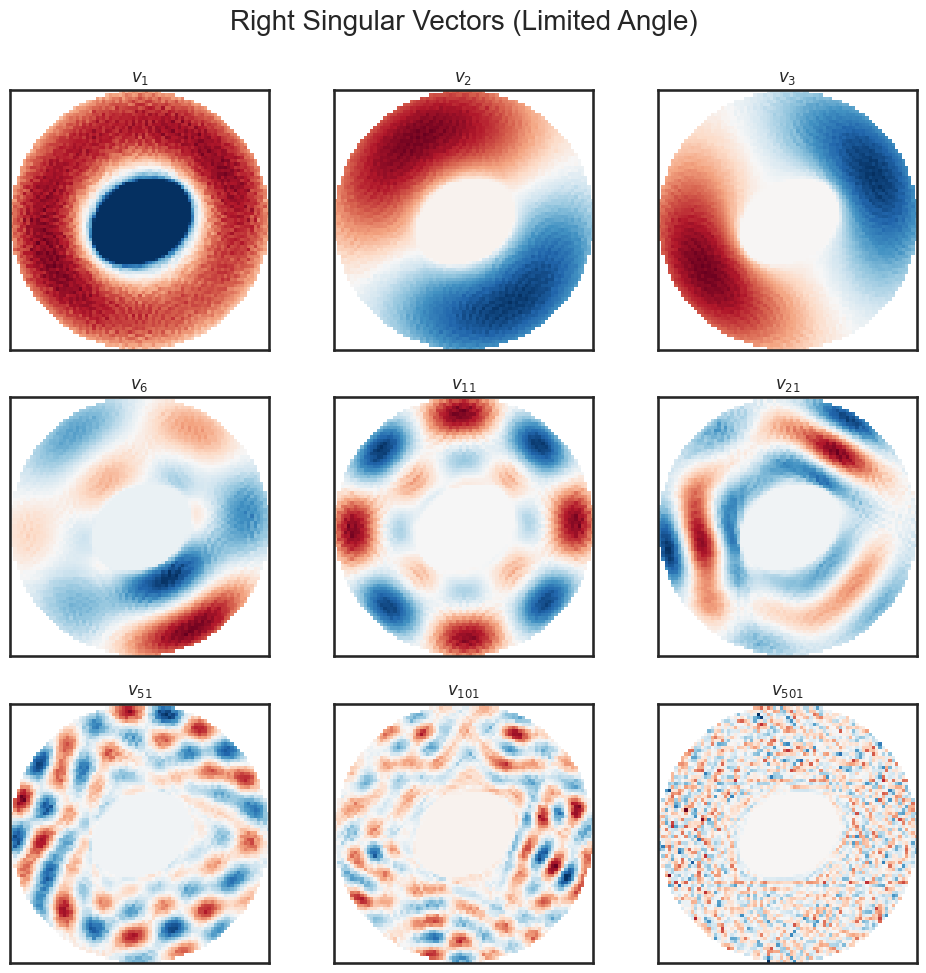

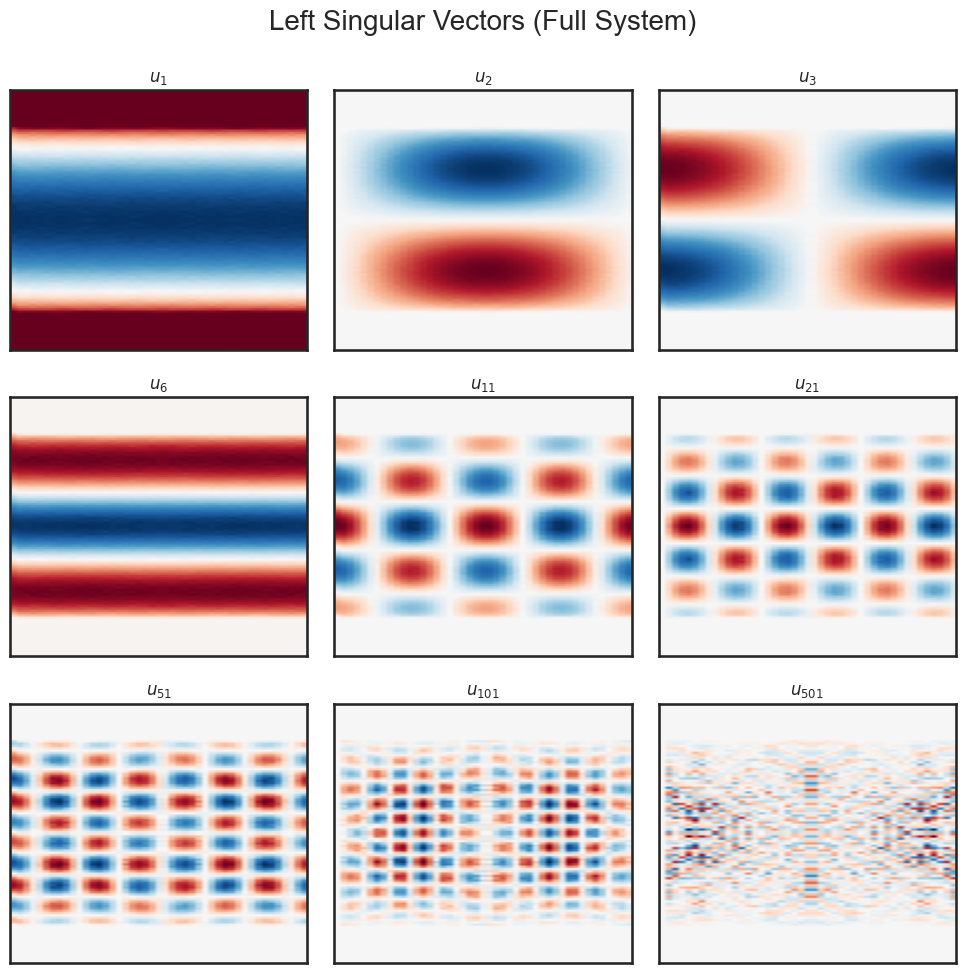

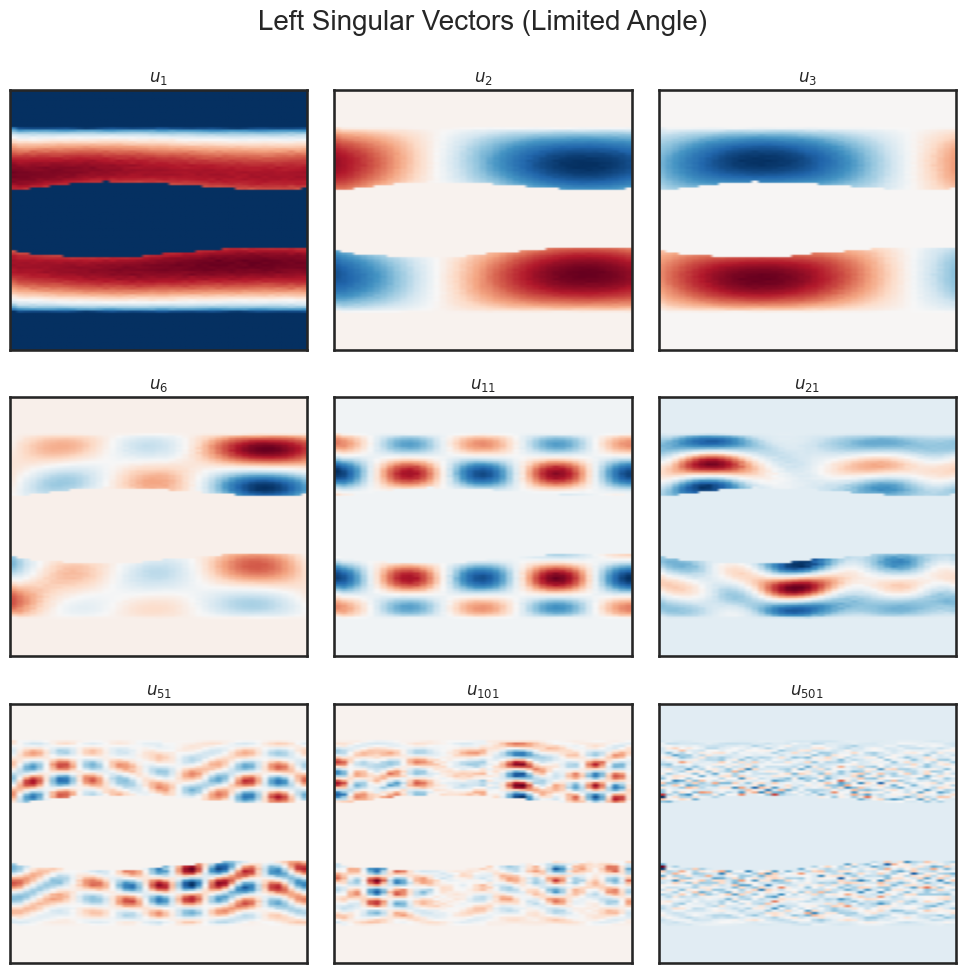

In [61]:
# SVD Vectors Visualization - Full System
# Show selected right (V) singular vectors in 3x3 layout

vec_indices = [0, 1, 2, 5, 10, 20, 50, 100, 500]

# Select which singular vectors to display (9 for 3x3)
vec_indices_full = vec_indices
vec_indices_full = [i for i in vec_indices_full if i < k_svd][:9]  # Filter valid indices, max 9

n_rows = 3
n_cols = 3

# Create figure with 3x3 layout for full system
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axs = axs.flatten()

# Right singular vectors V (reshaped to image)
for i, idx in enumerate(vec_indices_full):
    v_vec = VT[idx, :]  # V^T row = V column
    v_img = vector_to_rect_domain(v_vec, N)  # Reshape to image
    im = axs[i].imshow(v_img, cmap="RdBu_r")
    axs[i].set_title(f"$v_{{{idx+1}}}$", fontsize=12)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Hide any unused subplots
for i in range(len(vec_indices_full), n_rows * n_cols):
    axs[i].axis('off')

plt.suptitle("Right Singular Vectors (Full System)", fontsize=20, y=0.98)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "svd_vectors_full.png", dpi=600, bbox_inches="tight")
plt.show()

# SVD Vectors Visualization - Limited Angle System
# Sort by descending singular values
idx_l = np.argsort(S_l)[::-1]
U_l_sorted = U_l[:, idx_l]
S_l_sorted = S_l[idx_l]
VT_l_sorted = VT_l[idx_l, :]

k_svd_l = len(S_l_sorted)

# Select which singular vectors to display (9 for 3x3)
vec_indices_limited = vec_indices
vec_indices_limited = [i for i in vec_indices_limited if i < k_svd_l][:9]  # Filter valid indices, max 9

# Create figure with 3x3 layout for limited angle system
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axs = axs.flatten()

# Right singular vectors V (reshaped to image)
for i, idx in enumerate(vec_indices_limited):
    v_vec = VT_l_sorted[idx, :]  # V^T row = V column
    v_img = vector_to_rect_domain(v_vec, N)  # Reshape to image
    im = axs[i].imshow(v_img, cmap="RdBu_r")
    axs[i].set_title(f"$v_{{{idx+1}}}$", fontsize=12)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Hide any unused subplots
for i in range(len(vec_indices_limited), n_rows * n_cols):
    axs[i].axis('off')

plt.suptitle("Right Singular Vectors (Limited Angle)", fontsize=20, y=0.98)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "svd_vectors_limited.png", dpi=600, bbox_inches="tight")
plt.show()

# Left Singular Vectors Visualization - Full System
# Show selected left (U) singular vectors in 3x3 layout (sinogram space)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axs = axs.flatten()

# Left singular vectors U (reshaped to sinogram)
for i, idx in enumerate(vec_indices_full):
    u_vec = U[:, idx].reshape(M, p).T  # Reshape to sinogram shape
    im = axs[i].imshow(u_vec, aspect="auto", cmap="RdBu_r")
    axs[i].set_title(f"$u_{{{idx+1}}}$", fontsize=12)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Hide any unused subplots
for i in range(len(vec_indices_full), n_rows * n_cols):
    axs[i].axis('off')

plt.suptitle("Left Singular Vectors (Full System)", fontsize=20, y=0.98)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "svd_u_vectors_full.png", dpi=600, bbox_inches="tight")
plt.show()

# Left Singular Vectors Visualization - Limited Angle System
# Show selected left (U) singular vectors in 3x3 layout (sinogram space)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axs = axs.flatten()

# Left singular vectors U (reshaped to sinogram)
for i, idx in enumerate(vec_indices_limited):
    u_vec = U_l_sorted[:, idx].reshape(M, p).T  # Reshape to sinogram shape
    im = axs[i].imshow(u_vec, aspect="auto", cmap="RdBu_r")
    axs[i].set_title(f"$u_{{{idx+1}}}$", fontsize=12)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Hide any unused subplots
for i in range(len(vec_indices_limited), n_rows * n_cols):
    axs[i].axis('off')

plt.suptitle("Left Singular Vectors (Limited Angle)", fontsize=20, y=0.98)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "svd_u_vectors_limited.png", dpi=600, bbox_inches="tight")
plt.show()